In [2]:
from torchvision import datasets, transforms
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from torch import nn, optim
import torch.nn.functional as F
import skimage.io as io
import matplotlib.pyplot as plt

In [3]:
from model import LeNet
from eval_model import evaluate_model
import mnist_loader

In [4]:
from tqdm import tqdm

In [5]:
model=LeNet()
# Model class must be defined somewhere
model = torch.load('lenet_model')
model.eval()

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [6]:
learning_rate=.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
epoches=20
bs=32

In [77]:
train_set, test_set=mnist_loader.get_x_and_y()

In [8]:
import torch.nn.utils.prune as prune

In [10]:
result=evaluate_model(model,test)

In [61]:
from train import Trainer
train=Trainer(model, train, criterion, optimizer, epoches, 100)

In [12]:
baseline=result.evaluate()

In [13]:
baseline=int(baseline)

In [14]:
model.state_dict

<bound method Module.state_dict of LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)>

In [15]:
model.modules()

<generator object Module.modules at 0x7fe72b53bac0>

In [65]:
# module_tups = []
# for module in model.modules():
#     module_tups.append((module, 'weight'))
# modules=module_tups[1:]
# modules[0].state

In [95]:
# modules[0][0].state_dict()

In [16]:
def prune_model_global_unstructured(model, layer_type, proportion):
    module_tups = []
    for module in model.modules():
        if isinstance(module, layer_type):
            module_tups.append((module, 'weight'))

    prune.global_unstructured(
        parameters=module_tups, pruning_method=prune.L1Unstructured,
        amount=proportion
    )
    
    
    for module, _ in module_tups:
        prune.remove(module, 'weight')
    return model


In [17]:
prune_model_global_unstructured()

TypeError: prune_model_global_unstructured() missing 3 required positional arguments: 'model', 'layer_type', and 'proportion'

# https://spell.ml/blog/model-pruning-in-pytorch-X9pXQRAAACIAcH9h

In [18]:
def countZeroWeights(model):
    zeros = 0
    for param in model.parameters():
        if param is not None:
            zeros += torch.sum((param == 0).int()).item()
    return zeros

In [118]:
countZeroWeights(model)

59838

In [19]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [108]:
for p in model.parameters() :
    if p.requires_grad:
        print(p.shape)

torch.Size([6])
torch.Size([6, 1, 3, 3])
torch.Size([16])
torch.Size([16, 6, 3, 3])
torch.Size([120])
torch.Size([120, 400])
torch.Size([84])
torch.Size([84, 120])
torch.Size([10])
torch.Size([10, 84])


In [56]:
rates=[.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0]
Acc_trace={}

for rate in tqdm(rates):
    
#     prune
    modules=[]
    
    for module in model.modules():
        modules.append((module, 'weight'))
    
    modules=modules[1:]
    
    print('Rate ... ',rate )
    prune.global_unstructured(parameters=modules, pruning_method=prune.L1Unstructured,amount=rate)

    zeros=countZeroWeights(model)
    
    print('Non zero/ total ... ', (total_params-zeros/total_params ), ' zeros now :', zeros)
    
    for module, _ in modules:
        prune.remove(module, 'weight')
    
    result=evaluate_model(model,test)    

    Acc_trace[rate]=result.evaluate()
    print('Evaluating new model ... ',list(Acc_trace.values())[-1],'\n')
    
#     check accuracy


    '''
    change mode to train mode
        re-train from the existing weights
        until accuracy is preserved
        
        
    '''

    

  0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?it/s]

Rate ...  0.1
Non zero/ total ...  60073.0039284882  zeros now : 59838


 10%|█████████████████▌                                                                                                                                                             | 1/10 [00:00<00:07,  1.17it/s]

Evaluating new model ...  8.921784356871374 

Rate ...  0.2
Non zero/ total ...  60073.0039284882  zeros now : 59838


 20%|███████████████████████████████████                                                                                                                                            | 2/10 [00:01<00:05,  1.40it/s]

Evaluating new model ...  8.921784356871374 

Rate ...  0.3
Non zero/ total ...  60073.0039284882  zeros now : 59838


 30%|████████████████████████████████████████████████████▌                                                                                                                          | 3/10 [00:01<00:03,  1.76it/s]

Evaluating new model ...  8.921784356871374 

Rate ...  0.4
Non zero/ total ...  60073.0039284882  zeros now : 59838


 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 4/10 [00:01<00:02,  2.12it/s]

Evaluating new model ...  8.921784356871374 

Rate ...  0.5
Non zero/ total ...  60073.0039284882  zeros now : 59838


 50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:01<00:02,  2.49it/s]

Evaluating new model ...  8.921784356871374 

Rate ...  0.6
Non zero/ total ...  60073.0039284882  zeros now : 59838


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 6/10 [00:02<00:01,  2.90it/s]

Evaluating new model ...  8.921784356871374 

Rate ...  0.7
Non zero/ total ...  60073.0039284882  zeros now : 59838


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 7/10 [00:02<00:00,  3.14it/s]

Evaluating new model ...  8.921784356871374 

Rate ...  0.8
Non zero/ total ...  60073.0039284882  zeros now : 59838


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 8/10 [00:02<00:00,  3.50it/s]

Evaluating new model ...  8.921784356871374 

Rate ...  0.9
Non zero/ total ...  60073.0039284882  zeros now : 59838


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 9/10 [00:02<00:00,  3.78it/s]

Evaluating new model ...  8.921784356871374 

Rate ...  1.0
Non zero/ total ...  60073.0039284882  zeros now : 59838


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.26it/s]

Evaluating new model ...  8.921784356871374 



In [21]:
Acc_trace.values()

dict_values([96.92938587717543, 96.81936387277456, 94.95899179835968, 91.5483096619324, 79.46589317863572, 76.3252650530106, 67.35347069413882, 31.94638927785557, 12.13242648529706, 8.921784356871374])

In [22]:
import matplotlib.pyplot as plt

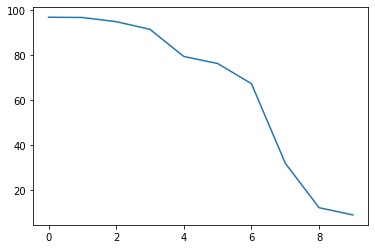

In [32]:
plt.plot(list(Acc_trace.values()))

In [42]:
modules[0]

(Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1)), 'weight')

In [57]:
# model.conv1.state_dict()

In [58]:
baseline*5

97

In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [71]:
train.training()

  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]


TypeError: 'Trainer' object is not iterable

In [82]:
for epoch in range( epoches):
        for i, (images, labels) in enumerate( train_set): 
            images=images.reshape(-1,1,28,28).float()
            outputs =  model(images)   

            labels = labels.to( device)        
            # Forward pass

            loss =  criterion(outputs, labels)



      #Replaces pow(2.0) with abs() for L1 regularization

#                 l2_lambda = 0.001 hyperparameters
#                 l2_norm = sum(p.pow(2.0).sum()
#                               for p in model.parameters())

#                 loss = loss + l2_lambda * l2_norm

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print (loss.item())

In [92]:
# result=evaluate_model(model,test)    
last=result.evaluate()

In [93]:
last

3.784090151363606

In [95]:
train.training()

  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]


TypeError: 'Trainer' object is not iterable

In [100]:
baseline*.05

4.8500000000000005

In [111]:
def train_model():
    for epoch in range( epoches):
        for i, (images, labels) in enumerate( train_set): 
            images=images.reshape(-1,1,28,28).float()
            outputs =  model(images)   

            labels = labels.to( device)        
            # Forward pass

            loss =  criterion(outputs, labels)



      #Replaces pow(2.0) with abs() for L1 regularization

#                 l2_lambda = 0.001 hyperparameters
#                 l2_norm = sum(p.pow(2.0).sum()
#                               for p in model.parameters())

#                 loss = loss + l2_lambda * l2_norm

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print('Epoch : ', loss.item())

In [112]:
#     return model  
accuracy=0
bear=5
train=Trainer(model, train, criterion, optimizer, epoches, 100)

while accuracy <baseline*(bear/100):
    
    
    train_model()    
    
    
#     train
#         until accuracy is recovered
#     train.training()

    #      eval
    result=evaluate_model(model,test)  
    accuracy=result.evaluate()
#     Acc_trace[rate]=result.evaluate()


#     check percentage of prunned
    
#     if done break

Epoch :  2.306302785873413
Epoch :  2.3063762187957764
Epoch :  2.3064446449279785
Epoch :  2.306509256362915
Epoch :  2.3065695762634277
Epoch :  2.306626558303833
Epoch :  2.3066799640655518
Epoch :  2.306729793548584
Epoch :  2.306776762008667
Epoch :  2.30682110786438
Epoch :  2.3068623542785645
Epoch :  2.306901454925537
Epoch :  2.3069381713867188
Epoch :  2.3069722652435303
Epoch :  2.307004690170288
Epoch :  2.307034492492676
Epoch :  2.307063102722168
Epoch :  2.3070898056030273
Epoch :  2.307114362716675
Epoch :  2.3071377277374268


In [ ]:
model.

In [117]:
eval_model=evaluate_model(model,test)

In [118]:
acc=eval_model.evaluate()

In [119]:
acc

11.352270454090819

In [123]:
modules[0][0].state_dict()

OrderedDict([('bias',
              tensor([ 0.0322, -0.1876, -0.0309,  0.1002,  0.0660, -0.1587])),
             ('weight',
              tensor([[[[-1.9875e-17, -2.0083e-17, -2.1958e-17],
                        [-2.3534e-17, -2.4027e-17, -2.6104e-17],
                        [-2.7412e-17, -2.7924e-17, -3.0297e-17]]],
              
              
                      [[[-0.0000e+00,  0.0000e+00,  0.0000e+00],
                        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
                        [-0.0000e+00, -0.0000e+00, -0.0000e+00]]],
              
              
                      [[[ 0.0000e+00,  0.0000e+00, -0.0000e+00],
                        [-0.0000e+00, -0.0000e+00,  0.0000e+00],
                        [-0.0000e+00,  0.0000e+00,  0.0000e+00]]],
              
              
                      [[[-6.1803e-17, -6.2451e-17, -6.8279e-17],
                        [-7.3182e-17, -7.4714e-17, -8.1173e-17],
                        [-8.5239e-17, -8.6831e-17, -9.4212e-17]]